In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook

from neo4j import GraphDatabase

pd.set_option("max_columns", None)
pd.set_option("max_colwidth", None)
pd.set_option("max_rows", None)

## Import data 
In csv file the data is in triples <h, r, t> format.
We will import data into Dataframe in the columns ['head', 'relation', 'tail'] respectively.

In [2]:
df = pd.read_csv('data/7201_dataset_r2.csv', names=['head', 'relation', 'tail'])
df.head()

,head,relation,tail
0,P001,friend with,P002
1,P001,friend with,P006
2,P001,friend with,P008
3,P001,friend with,P011
4,P001,friend with,P012


Next, we want to know number of each relationship and unique node.

like           358
type of        305
is a           275
from            89
budget          65
player mode     50
use             47
friend with     39
part of         21
born in         14
in league        9
based in         9
Name: relation, dtype: int64


<AxesSubplot:xlabel='relation', ylabel='Count'>

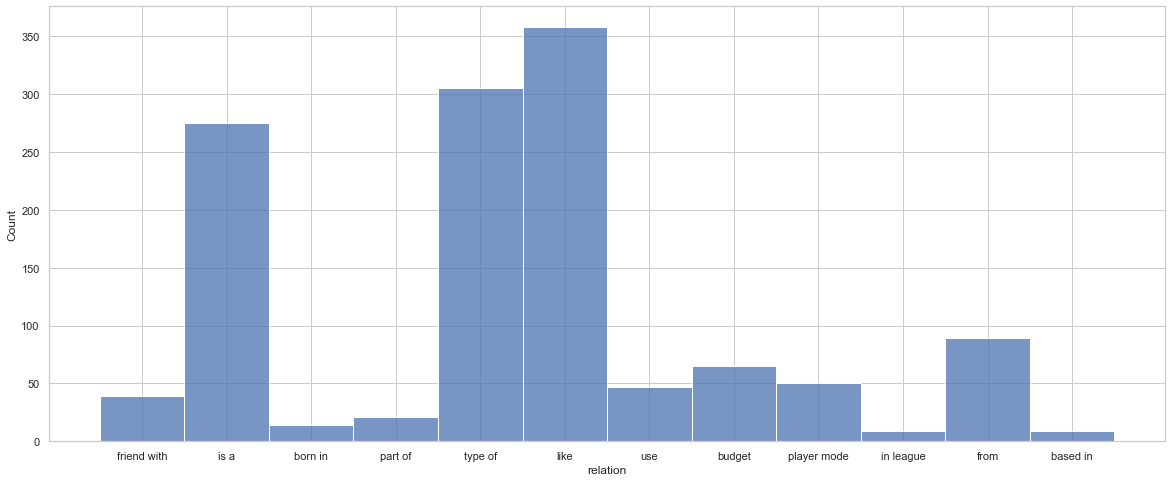

In [3]:
print(df['relation'].value_counts())

sns.set_theme(rc = {'figure.figsize':(20,8)},
              style="whitegrid")
sns.histplot(data=df['relation'])

In [4]:
print(f"Number of unique node: {pd.concat([df['head'],df['tail']]).nunique()}")

Number of unique node: 378


## Explore Node label

**Exploring the "is a" relationship, <h, is a, t>, that means the node type in the head. Collected in `df_is_a` dataframe**

In [5]:
df_is_a = df[df['relation'] == 'is a']
df_is_a

,head,relation,tail
39,P001,is a,PERSON
40,P002,is a,PERSON
41,P003,is a,PERSON
42,P004,is a,PERSON
43,P005,is a,PERSON
44,P006,is a,PERSON
45,P007,is a,PERSON
46,P008,is a,PERSON
47,P009,is a,PERSON
48,P010,is a,PERSON


**Search for all types of nodes.**

In [6]:
type_is_a = df_is_a['tail'].unique()

print(f'Number of unique node types: {len(type_is_a)}')
print(type_is_a)

Number of unique node types: 17
['PERSON' 'PLACE' 'SOCIAL MEDIA' 'FOOD' 'PC GAME' 'MOBILE GAME'
 'BOARD GAME' 'FOOTBALL TEAM' 'BUFFET' 'SERIES' 'MOVIE' 'SINGER'
 'ACTOR/ACTRESS' 'SONGWRITER' 'MODEL' 'COUNTRY' 'CITY']


**Searches for nodes that have been assigned a type using a "is a" relationship, <h, is a, t>.**

In [7]:
node_defined = df_is_a['head'].unique()

print(f'Number of unique node that defined type: {len(node_defined)}')

Number of unique node that defined type: 275


**Searches for another node that has not yet been assigned a type, where these nodes are minor type.**

In [8]:
node_undefined = np.setdiff1d(pd.concat([df['head'],df['tail']], ignore_index=True), 
                              node_defined, 
                              assume_unique=False)

print(f'Number of unique node that defined type: {len(node_undefined)}')

Number of unique node that defined type: 103


**Assign a type to all nodes that are not yet defined as "TYPES" and append to `df_is_a` for assign node label in neo4j database.**

In [9]:
df_is_a = df_is_a.append(pd.DataFrame([[i, 'is a', 'TYPES'] for i in np.concatenate((type_is_a, node_undefined), axis=None)], 
                                      columns=df_is_a.columns), 
                         ignore_index=True)

**Finally, we get a total of 18 node types (that means label in neo4j) to create database.**

In [10]:
type_is_a = np.append('TYPES',type_is_a)

print(f'Number of unique node types: {len(type_is_a)}')
print(type_is_a)

Number of unique node types: 18
['TYPES' 'PERSON' 'PLACE' 'SOCIAL MEDIA' 'FOOD' 'PC GAME' 'MOBILE GAME'
 'BOARD GAME' 'FOOTBALL TEAM' 'BUFFET' 'SERIES' 'MOVIE' 'SINGER'
 'ACTOR/ACTRESS' 'SONGWRITER' 'MODEL' 'COUNTRY' 'CITY']


## Connect to neo4j

**We need to define a connection class to connect to the graph database.**  
https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python-4172d40f89c4

In [11]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

**Connect to neo4j**

In [12]:
host = "bolt://localhost:7687"
user = "NittyNice"
password = "1234"

# connect to neo4j
conn = Neo4jConnection(uri=host, user=user, pwd=password)

**Prepare kays for setup table of each node.**

In [13]:
constraint_name = [i.lower().replace(' ', '_').replace('/', '_') for i in type_is_a]

short = ['type', 'person', 'place', 'media', 'food', 'pc', 'mobile', 'board', 'football', 'buffet', 
         'serie', 'movie', 'singer', 'actor', 'writer', 'model', 'country', 'city']

node_label = ['Types', 'Person', 'Place', 'Social_media', 'Food', 'PC_game', 'Mobile_game', 'Board_game', 'Football_team',
              'Buffet', 'TV_Series', 'Movie', 'Singer', 'Actors', 'Song_writer', 'Model', 'Country', 'City']

identify_description = ['type', 'person id', 'place name', 'social media', 'food name', 'pc game name', 'mobile game name', 
                        'board game name', 'football team name', 'buffet name', 'serie name', 'movie name', 'signer name', 
                        'actor/actress name', 'song writer name', 'model name', 'country name', 'city name']

create_table = pd.DataFrame({'constraint_name': constraint_name, 
                             'short': short, 
                             'node_label': node_label,
                             'identify_description': identify_description
                            }, index=type_is_a)

create_table

,constraint_name,short,node_label,identify_description
TYPES,types,type,Types,type
PERSON,person,person,Person,person id
PLACE,place,place,Place,place name
SOCIAL MEDIA,social_media,media,Social_media,social media
FOOD,food,food,Food,food name
PC GAME,pc_game,pc,PC_game,pc game name
MOBILE GAME,mobile_game,mobile,Mobile_game,mobile game name
BOARD GAME,board_game,board,Board_game,board game name
FOOTBALL TEAM,football_team,football,Football_team,football team name
BUFFET,buffet,buffet,Buffet,buffet name


**Create constraints constraints within the database that will ensure the nodes are not duplicates while also setting up some indexing.**

In [14]:
for ind, row in create_table.iterrows():
    conn.query(f'''CREATE CONSTRAINT {row['constraint_name']} IF NOT EXISTS 
                   ON ({row['short']}:{row['node_label']}) 
                   ASSERT {row['short']}.identify_name IS UNIQUE
               ''')

**Add nodes**

In [15]:
def add_nodes(data, short, node_label, identify_description):
    # Adds nodes to the Neo4j graph.
  
    query = f'''UNWIND $rows AS row 
            MERGE ({short}:{node_label} {{identify_name: row.head, identify_description: "{identify_description}"}})
            '''
    
    return conn.query(query, parameters={'rows': data.to_dict('records')})

In [16]:
for ind, row in create_table.iterrows():
    
    nodes_data = pd.DataFrame(df_is_a[df_is_a['tail'] == ind]['head'])

    add_nodes(nodes_data, row['short'], row['node_label'], row['identify_description'])

In [17]:
# Example node data in records
nodes_data.to_dict('records')

[{'head': 'MANCHESTER'},
 {'head': 'FULHAM'},
 {'head': 'BARCELONA'},
 {'head': 'ISLINGTON'},
 {'head': 'MADRID'},
 {'head': 'LIVERPOOL'},
 {'head': 'PARIS'}]

**Add relations**

In [18]:
def add_relations(data, node_label_h, node_label_t, relation):
    query = f'''UNWIND $rows as row
            MATCH 
                (h:{node_label_h} {{identify_name: row.head}}),
                (t:{node_label_t} {{identify_name: row.tail}})
            MERGE (h)-[:{relation}]->(t)
            '''
    
    return conn.query(query, parameters={'rows': data.to_dict('records')})

In [19]:
for relation in tqdm_notebook(df['relation'].unique()):
    relation_data = df[df['relation'] == relation]
    
    for ind_h, row_h in create_table.iterrows():
        for ind_t, row_t in create_table.iterrows():
            add_relations(relation_data, 
                          row_h['node_label'], 
                          row_t['node_label'], 
                          relation.replace(' ', '_')
                         )

  0%|          | 0/12 [00:00<?, ?it/s]

In [20]:
# Example relation data in records
relation_data.to_dict('records')

[{'head': 'MANCHESTER UNITED', 'relation': 'based in', 'tail': 'MANCHESTER'},
 {'head': 'CHELSEA', 'relation': 'based in', 'tail': 'FULHAM'},
 {'head': 'BARCELONA FC', 'relation': 'based in', 'tail': 'BARCELONA'},
 {'head': 'ARSENAL', 'relation': 'based in', 'tail': 'ISLINGTON'},
 {'head': 'REAL MADRID', 'relation': 'based in', 'tail': 'MADRID'},
 {'head': 'LIVERPOOL FC', 'relation': 'based in', 'tail': 'LIVERPOOL'},
 {'head': 'MANCHESTER CITY', 'relation': 'based in', 'tail': 'MANCHESTER'},
 {'head': 'ATLETICO MADRID', 'relation': 'based in', 'tail': 'MADRID'},
 {'head': 'PARIS SAINT GERMAIN', 'relation': 'based in', 'tail': 'PARIS'}]

### Neo4j to PyKEEN and AmpliGraph

In [21]:
query = """
MATCH (h)-[r]->(t)
RETURN properties(h).identify_name as head, type(r) as relation, properties(t).identify_name AS tail
"""

records = conn.query(query)
records

[<Record head='BANGKOK AND SURROUNDING' relation='part_of' tail='THAILAND'>,
 <Record head='INCEPTION' relation='type_of' tail='ADVENTURE'>,
 <Record head='INCEPTION' relation='type_of' tail='SCIENCE FICTION'>,
 <Record head='INCEPTION' relation='type_of' tail='ACTION'>,
 <Record head='NORTH OF THAILAND' relation='part_of' tail='THAILAND'>,
 <Record head='NORTHEAST OF THAILAND' relation='part_of' tail='THAILAND'>,
 <Record head='SOUTH OF THAILAND' relation='part_of' tail='THAILAND'>,
 <Record head='STARDEW VALLEY' relation='player_mode' tail='SINGLE-PLAYER GAME'>,
 <Record head='STARDEW VALLEY' relation='player_mode' tail='MULTIPLAYER GAME'>,
 <Record head='STARDEW VALLEY' relation='budget' tail='MEDIUM COST'>,
 <Record head='STARDEW VALLEY' relation='type_of' tail='ROLE-PLAYING'>,
 <Record head='STARDEW VALLEY' relation='type_of' tail='INDIE'>,
 <Record head='STARDEW VALLEY' relation='type_of' tail='SIMULATION'>,
 <Record head='VEGETABLE STEW' relation='type_of' tail='LOCAL FOOD'>,
 <

In [22]:
# convert data in record to numpy array.
X = np.array([i.values() for i in records])
X

array([['BANGKOK AND SURROUNDING', 'part_of', 'THAILAND'],
       ['INCEPTION', 'type_of', 'ADVENTURE'],
       ['INCEPTION', 'type_of', 'SCIENCE FICTION'],
       ...,
       ['LIVERPOOL', 'is_a', 'CITY'],
       ['PARIS', 'part_of', 'FRANCE'],
       ['PARIS', 'is_a', 'CITY']], dtype='<U42')

**AmpliGraph can use data in a numpy array format.**  
https://medium.com/featurepreneur/ampligraph-what-is-it-8b243800818c

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen

num_test = int(len(X) * 0.2)
data['train'], data['test'] = train_test_split_no_unseen(X, 
                                                         test_size=num_test, 
                                                         seed=0, 
                                                         allow_duplication=False
                                                        ) 

**Pykeen TriplesFactory : classes for creating and storing training data from triples.**  
https://towardsdatascience.com/knowledge-graph-completion-with-pykeen-and-neo4j-6bca734edf43

In [ ]:
from pykeen.triples import TriplesFactory

triples = TriplesFactory.from_labeled_triples(X)

**Bonus!!**

In [ ]:
# convert data in record to dataframe for other uses.
df_r = pd.DataFrame(map(dict, a))
df_r.head()